In [1]:
import os

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from torchvision import transforms

from PIL import Image

import json

In [2]:
class SynthesisDataset(Dataset):
    '''The dataset for the ArchVizPro data
    '''
    def __init__(self, root_dir):

        # file locations
        self.root_dir = root_dir # file path of the image dataset
        self.file_list = os.listdir(self.root_dir) # gets all files in the directory
        self.img_list = [file for file in self.file_list if "img" in file] # only the images
        self.modalities = self.get_modalities() # all ground truths (rgb, semantic, outlines)
        self.dictionary = self.files_to_dict() # makes a dictionary out of image paths
        self.keys = list(self.dictionary.keys()) # all image sets (one image set contains multiple ground truths)
        self.meta_file = [file for file in self.file_list if "meta" in file]
        self.meta = self.load_json()

        # transformations
        self.toTensor = transforms.ToTensor() # from PIL image to Tensor
        self.toPilImage = transforms.ToPILImage() # Tensor to Pil Image

    def get_modalities(self):
        first_char = self.file_list[0][0]
        mods = [x for x in self.file_list if x.startswith(first_char)]
        return [x.replace('.', '_').split('_')[1] for x in mods]

    def files_to_dict(self):
        dictionary = {}
        for x in self.file_list:
            if x.endswith('.png'):
                if x.split('_')[0] not in dictionary.keys():
                    dictionary[x.split('_')[0]] = {}
                dictionary[x.split('_')[0]][x.replace('.', '_').split('_')[1]] = x

        return dictionary

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):      
        if torch.is_tensor(idx):
            idx = idx.tolist()

        images_dict = {}

        key = self.keys[idx]
        for mod in self.modalities:
            images_dict[mod] = self.toTensor(Image.open(os.path.join(
                self.root_dir, self.dictionary[key][mod])))

        return images_dict

    def show_imgdir(self, images_dict):
        return self.toPilImage(make_grid([images_dict[key] for key in self.modalities]))

    def load_json(self):
        with open(os.path.join(
                self.root_dir, self.meta_file[0])) as f:
            return json.load(f)


In [3]:
synthesis_dataset = SynthesisDataset("..\ArchViz_interface\output\MLDataset")

In [4]:
item = synthesis_dataset.__getitem__(0)

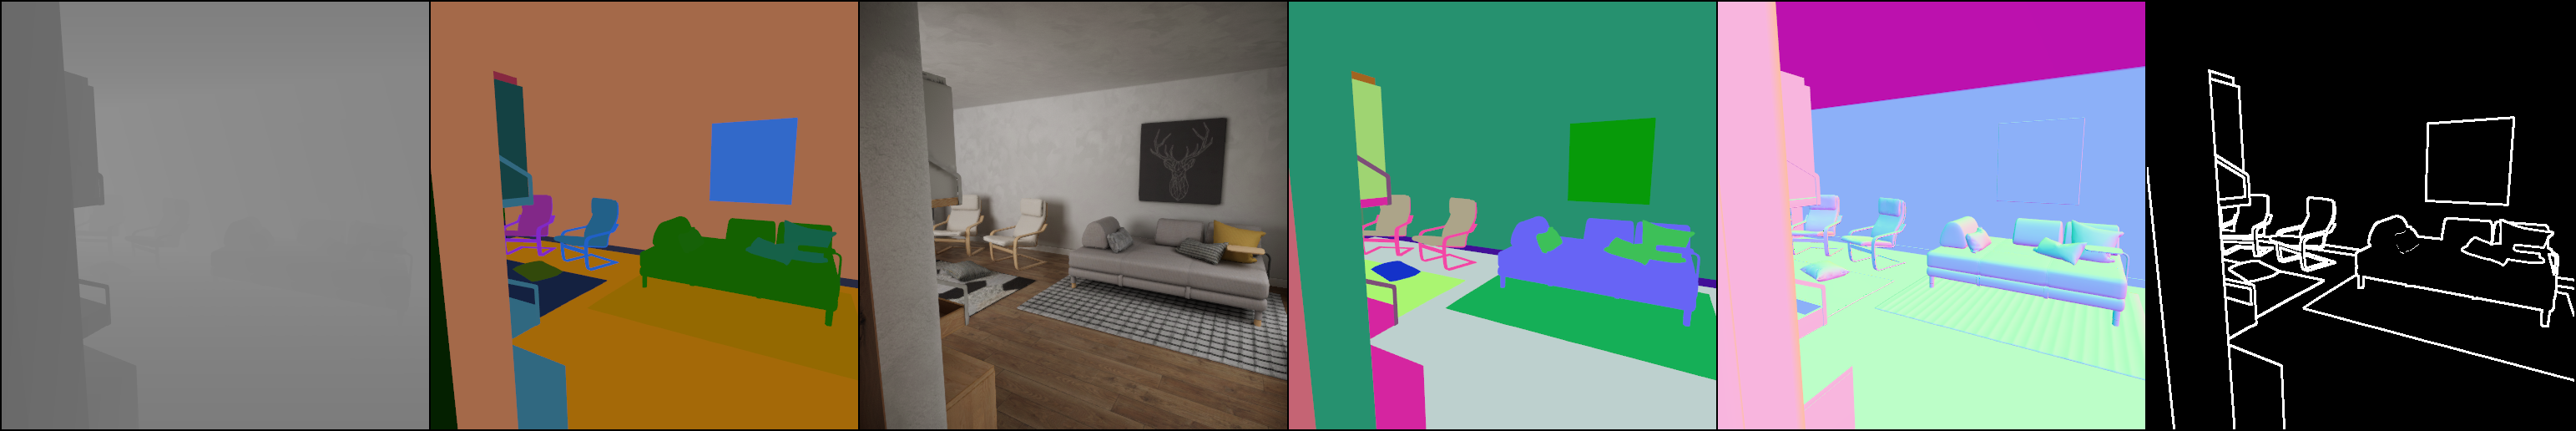

In [5]:
synthesis_dataset.show_imgdir(item)

In [6]:
meta = synthesis_dataset.meta

def dicttotensor(color):
    return torch.Tensor([color[value] for value in ['r', 'g', 'b']]).int()
    
namecolortonamedict = {}

for i, object in enumerate(meta):
    colortensor = dicttotensor(object['nameColor'])
    object['idcount'] = i
    object['colortensor'] = colortensor
    namecolortonamedict[str(colortensor)] = object

In [53]:
semantic_ids = torch.empty(item['layer'][0:1, :, :].shape)
intimg = (item['layer']*255).int().permute(1,2,0)

colors = namecolortonamedict.keys()

for color in colors:
    semantic_ids[(intimg == namecolortonamedict[color]['colortensor'])[:, :, 0:1].permute(
        2,0,1)] = namecolortonamedict[color]['idcount']

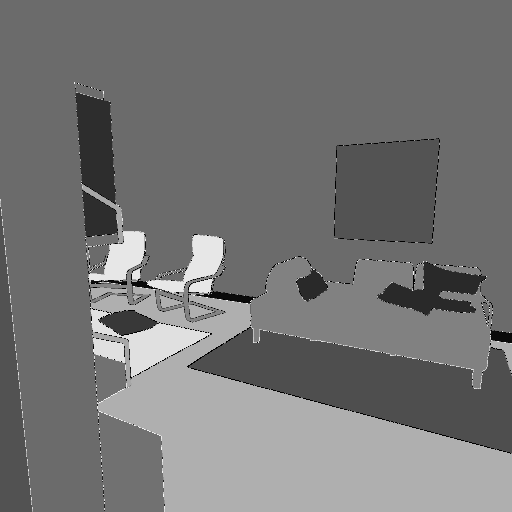

In [54]:
synthesis_dataset.toPilImage(semantic_ids)